In [1]:
import tensorflow as tf
from Function import *
from Jssp_env import JsspEnv
from collections import deque
import random
import os
import time
import matplotlib.pyplot as plt
import numpy as np

input_size = 10
output_size = 7
learning_rate = 0.001
REPLAY_MEMORY = 50000
MAX_STEP_SIZE = 5000
dis = 0.7
num_episodes = 20000
epsilon = 1  # The probability of choosing a random action (in training). This decays as iterations increase. (0 to 1)
epsilonMinimumValue = 0.001 # The minimum value we want epsilon to reach in training. (0 to 1)

dqn_x_epi_list = list()
dqn_y_span_list = list()
q_x_epi_list = list()
q_y_span_list = list()

init = tf.global_variables_initializer()



In [2]:
def q_net_main():
    X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)
    W1 = tf.get_variable("W1", shape=[input_size, 100],
                     initializer=tf.contrib.layers.xavier_initializer())
    layer1 = tf.nn.tanh(tf.matmul(X, W1))
    W2 = tf.get_variable("W2", shape=[100, output_size],
                         initializer=tf.contrib.layers.xavier_initializer())

    Qpred = tf.matmul(layer1, W2)
    Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)

    loss = tf.reduce_sum(tf.square(Y - Qpred))
    train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    save_list = list()
    min_span = 28
    best_reward = 0
    best_map = list()
    
    past_span = -1
    cnt = 0
    start = time.time()
    global q_x_epi_list
    global q_y_span_list
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for episode in range(num_episodes):
            ##m_busy_table + j_busy_table + order + tp = state(s)
            
            step_count = 0
            s = env.reset()
            
            #e = 1. / ((i / 100) + 2) #똑같은 행동만하는 것을 방지하기 위함
            #전체 reward
            reward_sum = 0
            done = False
            local_loss = []
            while not done:
                #[1, output_size]
                #machine busy, job busy, job order, throughput
                Qs = sess.run(Qpred, feed_dict={X: s}) 
                global epsilon
                if np.random.rand(1) < epsilon:
                    a = env.action_space.sample()
                else:
                    a = np.argmax(Qs)
                    
                if (epsilon > epsilonMinimumValue):
                    epsilon = epsilon * 0.999    

                s1, reward, done, _ = env.step(a)

                if done:
                    Qs[0, a] = reward
                else:
                    Qs1 = sess.run(Qpred, feed_dict={X: s1})
                    Qs[0, a] = reward + dis * np.max(Qs1)
                sess.run(train, feed_dict={X: s, Y: Qs})
                reward_sum += reward
                s = s1
                step_count += 1
                if step_count > MAX_STEP_SIZE:
                    break
            
            
            curr_span = makespan(env.map)
            
            #해당 if문 기준으로 past,curr 결정
            if(episode % 1000 == 0):
                print("episode : ",episode)
            
            
            if (curr_span < 27):
                if(curr_span == past_span):
                    cnt += 1
                else:
                    cnt = 0
                
                past_span = curr_span
            
            else:
                cnt = 0
                
            if(episode % 10 == 1 and s[0,6] == 1 and s[0,7] == 1 and s[0,8] == 1 and curr_span<27):
                q_x_epi_list.append(episode)
                q_y_span_list.append(curr_span)                
            
            if(cnt >1000):
                print("[수렴] Span : ",curr_span)
                print("[걸린 시간(초)] : ",time.time() - start)
                print("[Episode] : %d ~ %d"%(episode-1000, episode))
            
            if(cnt >1000 and curr_span == 12):
                print("[수렴] Span : ",curr_span)
                print("[걸린 시간(초)] : ",time.time() - start)
                print("[Episode] : %d ~ %d"%(episode-1000, episode))
                break                    

    print("[complete] cnt : ",cnt,"duration(sec) : ",time.time() - start)        
    #print(save_list) 

In [3]:
class DQN:
    def __init__(self, session, input_size, output_size, name = "main"):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.net_name = name
        
        self._build_network()
    #h_size 10 > 100으로 변환
    def _build_network(self, h_size = 100, l_rate=0.001):
        with tf.compat.v1.variable_scope(self.net_name):
            self._X = tf.placeholder(shape=[None, self.input_size], dtype=tf.float32, name="input_x")
    
            #First layer of weights
            W1 = tf.get_variable("W1", shape=[self.input_size, h_size],initializer=tf.contrib.layers.xavier_initializer())
            layer1 = tf.nn.tanh(tf.matmul(self._X, W1))
            
            #Second layer of weights
            W2 = tf.get_variable("W2", shape=[h_size, self.output_size],initializer=tf.contrib.layers.xavier_initializer())
            
            #Q prediction
            self._Qpred = tf.matmul(layer1, W2)
            
        #we need to define the parts of the netword needed for learning a policy
        self._Y = tf.placeholder(shape=[None, self.output_size], dtype = tf.float32)
        
        #Loss function
        self._loss = tf.reduce_mean(tf.square(self._Y - self._Qpred))
        
        #Training
        self._train = tf.train.AdamOptimizer(learning_rate = l_rate).minimize(self._loss)
        
    def predict(self, state):
        x = np.reshape(state, [1,self.input_size])
        return self.session.run(self._Qpred, feed_dict={self._X:x})
    
    def update(self, x_stack, y_stack):
        return self.session.run([self._loss, self._train], feed_dict={self._X:x_stack, self._Y:y_stack})

In [4]:
def replay_train(mainDQN, targetDQN, train_batch):
    x_stack = np.empty(0).reshape(0, input_size)
    y_stack = np.empty(0).reshape(0, output_size)
    
    #Get stored information from buffer
    for state, action, reward, next_state, done in train_batch:
        Q = mainDQN.predict(state)
        
        if done:
            Q[0,action] = reward
        else:
            Q[0,action] = reward + dis * np.max(targetDQN.predict(next_state))
            
        y_stack = np.vstack([y_stack, Q])
        x_stack = np.vstack([x_stack, state])
    
    # Train network using target and predicted Q values on each episode
    return mainDQN.update(x_stack, y_stack)

def get_copy_var_ops(*, dest_scope_name = "target", src_scope_name = "main"):
    #copy variables src_scope to dest_scope
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
    return op_holder    

def bot_play2(mainDQN):
    s = env.reset()
    reward_sum = 0
    span = 30
    while True:
        #env.render()
        a = np.argmax(mainDQN.predict(s))
        s, reward, done, _ = env.step(a)
        reward_sum += reward
        if done:
            if(s[0,6] == 1 and s[0,7] == 1 and s[0,8] == 1):
                span = makespan(env.map)
                    
            else:
                pass
                #print("Not finish")
            return span,reward_sum

In [5]:
def dqn_main():
    #saver = tf.train.Saver()
    
    #store the previous observations in replay memory
    replay_buffer = deque()
    
    save_list = list()
    best_map = list()
    curr_map = list()
    global dqn_x_epi_list
    global dqn_y_span_list
    
    min_span = 28
    best_episode = 0
    best_reward = 0
    reward_sum = 0
    curr_span = 0
    past_span = -1
    cnt = 0
    start = time.time()
    
    with tf.Session() as sess:
        mainDQN = DQN(sess, input_size, output_size, name="main")
        targetDQN = DQN(sess, input_size, output_size, name="target")
        tf.global_variables_initializer().run()
        
        #initial copy q_net(main) -> target_net
        copy_ops = get_copy_var_ops(dest_scope_name="target",src_scope_name="main")
        
        sess.run(copy_ops)
        
        for episode in range(num_episodes):
            done=False
            step_count = 0
            state = env.reset()
            while not done:
                global epsilon
                if np.random.rand(1) < epsilon:  
                    action = env.action_space.sample()
                else:
                    action = np.argmax(mainDQN.predict(state))
                
                if (epsilon > epsilonMinimumValue):
                    epsilon = epsilon * 0.999
                    
                next_state, reward, done, _ = env.step(action)

                replay_buffer.append((state, action, reward, next_state, done))
                if len(replay_buffer) > REPLAY_MEMORY:
                    replay_buffer.popleft()
                
                state = next_state
                step_count += 1
                if step_count > MAX_STEP_SIZE:
                    break

            if step_count > MAX_STEP_SIZE:
                print("step_count > MAX_STEP_SIZE")
                pass
            
            if episode % 10 == 1:
                for _ in range(200): #modify
                    minibatch = random.sample(replay_buffer, 10)
                    loss, _ = replay_train(mainDQN, targetDQN, minibatch)
                sess.run(copy_ops)   
                
            curr_span, reward_sum = bot_play2(mainDQN)
            
            
            if(episode % 1000 == 1):
                print("episode : ",episode)
            
            if (curr_span < 27):
                #해당 if문 기점으로 past, curr 결정
                if(curr_span == past_span):
                    cnt += 1
                else:
                    cnt = 0
                
                past_span = curr_span
            
            else:
                cnt = 0
                
            
            if(episode % 10 == 1 and state[0,6] == 1 and state[0,7] == 1 and state[0,8] == 1 and curr_span<27):
                dqn_x_epi_list.append(episode)
                dqn_y_span_list.append(curr_span)
                
            
            if(cnt >1000):
                print("[수렴] Span : ",curr_span)
                print("[걸린 시간(초)] : ",time.time() - start)
                print("[Episode] : %d ~ %d"%(episode-1000, episode))
                
                
            if(cnt >1000 and curr_span <= 12):
                print("[수렴] Span : ",curr_span)
                print("[걸린 시간(초)] : ",time.time() - start)
                print("[Episode] : %d ~ %d"%(episode-1000, episode))
                env.render()
                
                break

    print("[complete] cnt : ",cnt,"duration(sec) : ",time.time() - start) 
    #print(save_list)       

In [ ]:
env = JsspEnv()
global num_episodes
num_episodes = 40000
q_net_main()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

episode :  0
episode :  1000


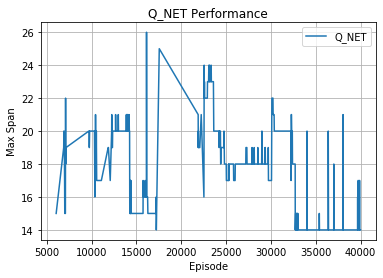

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(q_x_epi_list,q_y_span_list,label='Q_NET')

plt.title('Q_NET Performance')
plt.xlabel('Episode')
plt.ylabel('Max Span')

plt.legend()
plt.grid(True)
plt.show()


In [6]:
env = JsspEnv()
global num_episodes
num_episodes = 40000
dqn_main()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

episode :  1
episode :  1001
episode :  2001
episode :  3001
episode :  4001
episode :  5001
episode :  6001
episode :  7001
episode :  8001
[수렴] Span :  12.0
[걸린 시간(초)] :  1225.1324706077576
[Episode] : 7122 ~ 8122
[수렴] Span :  12.0
[걸린 시간(초)] :  1225.1331157684326
[Episode] : 7122 ~ 8122
1 | 1 | 1 | 2 | 2 | 3 | 3 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 

0 | 3 | 3 | 3 | 0 | 1 | 1 | 1 | 2 | 2 | 2 | 2 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 

0 | 0 | 0 | 0 | 0 | 2 | 2 | 2 | 3 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0

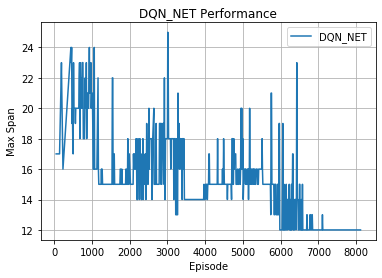

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(dqn_x_epi_list,dqn_y_span_list,label='DQN_NET')

plt.title('DQN_NET Performance')
plt.xlabel('Episode')
plt.ylabel('Max Span')

plt.legend()
plt.grid(True)
plt.show()